# B


In [15]:
# CELL 1 - Import
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# CELL 2 - Load & Preprocess
df = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/GSARPC3.csv')
df['smiles'] = df['smiles'].str.upper()

# Encode label
df['target'] = df['categories'].apply(lambda x: 1 if x == "inhibitor" else 0)
print("Distribusi label:")
print(df['target'].value_counts(normalize=True))

# Stratified split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target']
)

Distribusi label:
target
0    0.504717
1    0.495283
Name: proportion, dtype: float64


In [17]:
# CELL 3 - SMILES → Integer Sequence (WITH PADDING & mask_zero)
all_chars = set(''.join(df['smiles']))
charset = sorted(all_chars)
char_to_int = {c: i+1 for i, c in enumerate(charset)}  # 1,2,3,...
char_to_int['<PAD>'] = 0  # padding token
vocab_size = len(char_to_int)

MAX_LEN = min(250, max(len(s) for s in df['smiles']) + 5)

def smiles_to_seq(smiles_list, max_len):
    seqs = []
    for s in smiles_list:
        seq = [char_to_int.get(c, 0) for c in s]
        if len(seq) > max_len:
            seq = seq[:max_len]
        else:
            seq += [0] * (max_len - len(seq))  # PAD
        seqs.append(seq)
    return np.array(seqs, dtype=np.int32)

X_train = smiles_to_seq(df_train['smiles'].tolist(), MAX_LEN)
X_test = smiles_to_seq(df_test['smiles'].tolist(), MAX_LEN)
y_train = df_train['target'].values.astype(np.float32)
y_test = df_test['target'].values.astype(np.float32)

print(f"X_train: {X_train.shape} | vocab: {vocab_size} | max_len: {MAX_LEN}")

X_train: (508, 168) | vocab: 28 | max_len: 168


In [18]:
# CELL 4 - Build SMILES2VEC + LSTM (NO Bidirectional, Conv1D opsional)
def build_model(
    embedding_dim=64,
    use_conv=False,           # bisa False untuk pure SMILES2Vec
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,
    dropout_rate=0.5,
    learning_rate=0.001
):
    model = Sequential()
    
    # === SMILES2VEC: Embedding Layer (trainable) ===
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=MAX_LEN,
        mask_zero=True,       # ignore <PAD>
        name='smiles2vec'
    ))
    
    # Optional Conv1D
    if use_conv:
        model.add(Conv1D(conv_filters, conv_kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
    
    # LSTM (unidirectional only)
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )
    return model

In [19]:
# CELL 5 - Train & Evaluasi
# Class weight
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {0: weights[0], 1: weights[1]}
print(f"Class weights: {class_weight_dict}")

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_smiles2vec.keras', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Build & Train
model = build_model(
    embedding_dim=64,
    use_conv=False,        # pure SMILES2Vec
    lstm_units=128,
    dropout_rate=0.5,
    learning_rate=0.001
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Class weights: {0: 0.9921875, 1: 1.007936507936508}
Epoch 1/200


/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step - AUC: 0.4886 - Precision: 0.4920 - Recall: 0.7341 - accuracy: 0.4921 - loss: 0.6934 - val_AUC: 0.6698 - val_Precision: 0.4880 - val_Recall: 0.9683 - val_accuracy: 0.4844 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 2/200
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - AUC: 0.6548 - Precision: 0.4516 - Recall: 1.0000 - accuracy: 0.4688 - loss: 0.6934

/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - AUC: 0.6228 - Precision: 0.6100 - Recall: 0.5833 - accuracy: 0.6083 - loss: 0.6863 - val_AUC: 0.6510 - val_Precision: 0.6167 - val_Recall: 0.5873 - val_accuracy: 0.6172 - val_loss: 0.6784 - learning_rate: 0.0010
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - AUC: 0.6364 - Precision: 0.6073 - Recall: 0.6627 - accuracy: 0.6201 - loss: 0.6729 - val_AUC: 0.6531 - val_Precision: 0.6207 - val_Recall: 0.5714 - val_accuracy: 0.6172 - val_loss: 0.6582 - learning_rate: 0.0010
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - AUC: 0.6648 - Precision: 0.6154 - Recall: 0.6667 - accuracy: 0.6280 - loss: 0.6548 - val_AUC: 0.6635 - val_Precision: 0.6552 - val_Recall: 0.6032 - val_accuracy: 0.6484 - val_loss: 0.6486 - learning_rate: 0.0010
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - AUC: 0.6861 - Precision: 0.6575 - Recall: 0.6627 - accuracy: 0.6614 - loss: 0.6411 - val_AUC: 0.6729 - val_Precision: 0.6056 - val_Recall: 0.6825 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

=== SMILES2VEC + LSTM (BASE) ===
ROC-AUC: 0.6916
              precision    recall  f1-score   support

     Neutral       0.67      0.74      0.70        65
   Inhibitor       0.70      0.62      0.66        63

    accuracy                           0.68       128
   macro avg       0.68      0.68      0.68       128
weighted avg       0.68      0.68      0.68       128



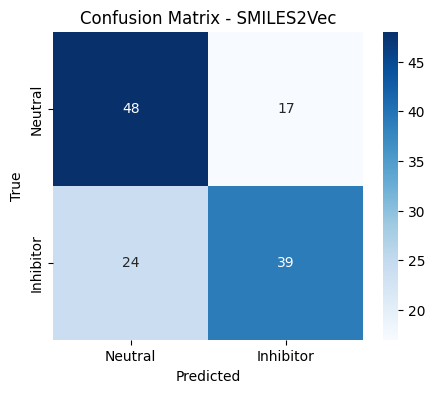

In [20]:
# CELL 6 - Evaluasi Lengkap
from tensorflow.keras.models import load_model
model = load_model('best_smiles2vec.keras')

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n=== SMILES2VEC + LSTM (BASE) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SMILES2Vec')
plt.show()

# C


In [21]:
# CELL 1 - Import
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# CELL 2 - Load & Preprocess
df = pd.read_csv('/home/dito-adistya/Dito/TA/Coding/LSTM-MBA/data/GSARPC3.csv')
df['smiles'] = df['smiles'].str.upper()

# Encode label
df['target'] = df['categories'].apply(lambda x: 1 if x == "inhibitor" else 0)
print("Distribusi label:")
print(df['target'].value_counts(normalize=True))

# Stratified split
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['target']
)

Distribusi label:
target
0    0.504717
1    0.495283
Name: proportion, dtype: float64


In [23]:
# CELL 3 - SMILES → Integer Sequence (WITH PADDING & mask_zero)
all_chars = set(''.join(df['smiles']))
charset = sorted(all_chars)
char_to_int = {c: i+1 for i, c in enumerate(charset)}  # 1,2,3,...
char_to_int['<PAD>'] = 0  # padding token
vocab_size = len(char_to_int)

MAX_LEN = min(250, max(len(s) for s in df['smiles']) + 5)

def smiles_to_seq(smiles_list, max_len):
    seqs = []
    for s in smiles_list:
        seq = [char_to_int.get(c, 0) for c in s]
        if len(seq) > max_len:
            seq = seq[:max_len]
        else:
            seq += [0] * (max_len - len(seq))  # PAD
        seqs.append(seq)
    return np.array(seqs, dtype=np.int32)

X_train = smiles_to_seq(df_train['smiles'].tolist(), MAX_LEN)
X_test = smiles_to_seq(df_test['smiles'].tolist(), MAX_LEN)
y_train = df_train['target'].values.astype(np.float32)
y_test = df_test['target'].values.astype(np.float32)

print(f"X_train: {X_train.shape} | vocab: {vocab_size} | max_len: {MAX_LEN}")

X_train: (508, 168) | vocab: 28 | max_len: 168


In [ ]:
# CELL 4 - FIXED MODEL (NO BUG, RINGKAS, KUAT)
def build_model(
    embedding_dim=128,
    use_conv=True,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,      # cukup untuk 636 data
    dropout_rate=0.5,
    learning_rate=0.001  # mulai lebih tinggi!
):
    model = Sequential()
    
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=MAX_LEN,
        mask_zero=True
    ))
    
    if use_conv:
        model.add(Conv1D(conv_filters, conv_kernel_size, activation='relu', padding='same'))
        model.add(BatchNormalization())
    
    # HANYA 1 LSTM → RINGKAS & STABIL
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )
    return model

In [40]:
# CELL 5 - TRAIN DENGAN SETTING AMAN
model = build_model(
    embedding_dim=128,
    use_conv=False,
    conv_filters=64,
    conv_kernel_size=5,
    lstm_units=128,
    dropout_rate=0.5,
    learning_rate=0.001  # mulai tinggi!
)

callbacks = [
    EarlyStopping(monitor='val_auc', mode='max', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),  # lebih sabar
    ModelCheckpoint('fixed_model.keras', monitor='val_auc', mode='max', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,           # naikkan!
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - AUC: 0.5144 - Precision: 0.5172 - Recall: 0.4167 - accuracy: 0.5177 - loss: 0.6930 - val_AUC: 0.5796 - val_Precision: 0.5469 - val_Recall: 0.5556 - val_accuracy: 0.5547 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 2/100


/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/home/dito-adistya/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:276: UserWarning: Can save best model only with val_auc available.
  if self._should_save_model(epoch, batch, logs, filepath):


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - AUC: 0.5418 - Precision: 0.5188 - Recall: 0.5476 - accuracy: 0.5236 - loss: 0.6902 - val_AUC: 0.6239 - val_Precision: 0.5600 - val_Recall: 0.6667 - val_accuracy: 0.5781 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - AUC: 0.5754 - Precision: 0.5594 - Recall: 0.5794 - accuracy: 0.5650 - loss: 0.6853 - val_AUC: 0.6418 - val_Precision: 0.5634 - val_Recall: 0.6349 - val_accuracy: 0.5781 - val_loss: 0.6715 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - AUC: 0.6096 - Precision: 0.5887 - Recall: 0.5794 - accuracy: 0.5906 - loss: 0.6770 - val_AUC: 0.6656 - val_Precision: 0.5909 - val_Recall: 0.6190 - val_accuracy: 0.6016 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - AUC: 0.6538 - Precision: 0.5793 - Recall: 0.7976 - accuracy: 0.6122 - loss: 0.6705 - val_AUC: 0.6736 - val_Precision: 0.6182 - val_Recall: 0.5397 - val_accu

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

=== SMILES2VEC + LSTM (BASE) ===
ROC-AUC: 0.7363
              precision    recall  f1-score   support

     Neutral       0.69      0.77      0.73        65
   Inhibitor       0.73      0.65      0.69        63

    accuracy                           0.71       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.71      0.71      0.71       128



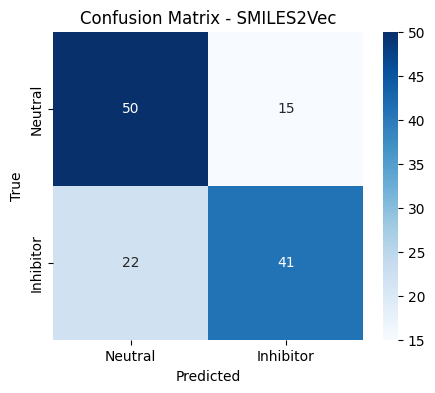

In [41]:
# CELL 6 - Evaluasi Lengkap
from tensorflow.keras.models import load_model
model = load_model('fixed_model.keras')

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n=== SMILES2VEC + LSTM (BASE) ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Inhibitor']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neutral', 'Inhibitor'],
            yticklabels=['Neutral', 'Inhibitor'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SMILES2Vec')
plt.show()

In [39]:
# HITUNG ULANG & PRINT
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {int(classes[0]): weights[0], int(classes[1]): weights[1]}

print("y_train distribusi:", np.bincount(y_train.astype(int)))
print("Class weights (0:Neutral, 1:Inhibitor):", class_weight_dict)

y_train distribusi: [256 252]
Class weights (0:Neutral, 1:Inhibitor): {0: 0.9921875, 1: 1.007936507936508}
